<a href="https://colab.research.google.com/github/PatchFramework/data-exploration-project/blob/main/data_exploration_anime_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration Project - Anime Recommendation
#### Team: PostgreSQL (Can Berkil, Canberk Alkan, Dominic Viola)
This Jupyter Notebook is designed to run on Google Colab, as it provides a standardized Linux environment and preinstalled applications. It contains the code that is used to download and analyse an Anime dataset. Afterwards the dataset is used to build a recommendation engine.



## Development Notes:

ToDo:

1. Headings and their content for: 
- Data selection (why did we choose this dataset? <- use information from Canberks PowerPoint) <- Canberk
- Data cleaning ###finished###
- Data transformation <- Canberk(GroupBy)
- Data exploration <- Can
- Model selection (papers to determine suitable algorithms) <- Dom
- Model Training <- Can
- Data Input for the Recommendation <- ?

# 0. Setup Environment

We use the package Tensorflow for out machine learning model. 

To use it efficiently we will use the GPU for Machine Learning operations. You need to activate it on Google Colab, otherwise CPU is selected by default. If you run this Notebook locally you need CUDA and cuDNN installed and have a Nvidia GPU with up-to-date drivers. You can find a tutorial [here](https://www.codingforentrepreneurs.com/blog/install-tensorflow-gpu-windows-cuda-cudnn/), however using Google Colab is recommended.

This will restart the notebook runtime environment.

Do the following steps:

1. Go to "Edit" in the top left corner of Google colab
2. Klick on "Notebook settings" in the dropdown menu
3. Select "GPU" and klick "Save"

Next up uncomment the next line if any dependencies are missing:

In [87]:
# Dependencies that are used for this Project
!pip install numpy pandas matplotlib seaborn tensorflow

In [88]:
%tensorflow_version 2.x
import tensorflow as tf
print(f"GPU is: {tf.test.gpu_device_name()}")

from tensorflow.python.client import device_lib
print("========== Details on GPU ==========")
print(device_lib.list_local_devices())

GPU is: /device:GPU:0
========== Details on GPU ==========
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4830868570065473177
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7799496173675897109
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 1. Download the dataset
The dataset is from Kaggle you can find general information about it [here](https://www.kaggle.com/CooperUnion/anime-recommendations-database?select=rating.csv).

I downloaded the dataset to my private google drive and created a public link to ensure that the dataset is available. This is in compliance with the dataset's Creative Commons License.

In [89]:
# Download the dataset from my google drive
!gdown --id 1XPYCQvsGq4cKp1liPmxPDd7QkU04Kj4X -O ./anime_dataset.zip
!ls

Downloading...
From: https://drive.google.com/uc?id=1XPYCQvsGq4cKp1liPmxPDd7QkU04Kj4X
To: /content/anime_dataset.zip
26.3MB [00:00, 63.4MB/s]
anime_dataset.zip  data  sample_data


In [90]:
# create a directory for the data
!mkdir data

# after downloading the dataset as a zip unzip the dataset into the new folder
# only execute if unzipped anime.csv doesn't already exist (cell can be re-run easier)
! [ ! -f data/anime.csv ] && unzip anime_dataset.zip -d ./data/

!ls data

mkdir: cannot create directory ‘data’: File exists
anime.csv  rating.csv


## 2. Data Selection

This section will shed a light on why [this](https://www.kaggle.com/CooperUnion/anime-recommendations-database?select=rating.csv) dataset was choosen and what the characteristics of the dataset are.

## 3. Fundamental dataset exploration

Now the content and structure of this dataset will explored.


Lets see how the csv files that were downloaded are structured.
Lets look at the first few lines of each file with the linux command "head".

The goal is to find information about:
- column names
- datatypes  
- the seperator (we need it for pandas later)
- how the CSV files are connected


In [91]:
!head -5 data/anime.csv

anime_id,name,genre,type,episodes,rating,members
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572


In [92]:
!head -5 data/rating.csv

user_id,anime_id,rating
1,20,-1
1,24,-1
1,79,-1
1,226,-1


What can be learned from this first peak into the dataset:
1. Columns in anime.csv
- "anime_id" is the identifier for each anime
- "name" contains the name as a string but without quotes
- "genre" contains all genres that the anime is part of, quotes are used, so that the comma seperated genres are not confused with csv fields
- "type" shows which medium type the anime is 
- "rating" seems to be a general rating from 1 to 10
- "members" ?

2. Columns in rating.csv
- "user" is the id of the user, that gave the rating
- "anime_id" is the identifier of the anime, this is the connecting field to anime.csv
- "rating" is the rating that the user gave the anime. There is -1 as an entry which can't be an actual rating, so -1 means, that the user watched but didn't rate the anime. If the user didn't watch and didn't rate the movie, there will be no entry in the rating.csv

3. The seperator is a comma for both csv-files


## 4. Data Cleaning
Unnecessary fields will be dropped from the dataset, the dataset will be checked for inconsistencies and redundancies. Also fields with incorrect datatypes will be fixed.

Pandas library will be used to save the dataset to dataframes for easier handling and manipulation in python. Numpy will help to modify values within the dataframe.



In [93]:
# Install the library packages (might be already installed)
!pip3 install pandas numpy

In [94]:
import pandas as pd
import numpy as np


In [95]:
anime_df = pd.read_csv("data/anime.csv")
rating_df = pd.read_csv("data/rating.csv")

In [96]:
anime_df


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [97]:
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [98]:
# Total amount of Anime in this dataset
len(anime_df["anime_id"])

12294

In [99]:
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [100]:
# Existing columns in anime_df and rating_df
anime_df.columns
rating_df.columns

"""
Keep in mind that both anime_df and rating_df do have the attribute "anime_id".
This will be important to merge both DataFrames.
"""

'\nKeep in mind that both anime_df and rating_df do have the attribute "anime_id".\nThis will be important to merge both DataFrames.\n'

In [101]:
# Cleaning anime dataframe
# Since members is not needed for the data analysis, it can be dropped
anime_df.drop(columns=["members", "rating"], inplace=True)

anime_df["genre"] = anime_df["genre"].replace(np.nan, "undefinied")
anime_df["type"] = anime_df["type"].replace(np.nan, "undefinied")
# Replace all instances of nan or none or null in the dataset to prevent errors 
#anime_df.replace([None, nan, null], value="undefinied")
anime_df[anime_df.genre == "undefinied"]

,anime_id,name,genre,type,episodes
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,undefinied,Special,1
3541,33589,ViVid Strike!,undefinied,TV,12
6040,29765,Metropolis (2009),undefinied,Movie,1
6646,32695,Match Shoujo,undefinied,ONA,1
7018,33187,Katsudou Shashin,undefinied,Movie,1
...,...,...,...,...,...
11070,32032,Seikaisuru Kado,undefinied,undefinied,Unknown
11086,34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,undefinied,Movie,1
11097,34474,Tsukipro The Animation,undefinied,TV,Unknown
11112,33035,Yuyushiki Special,undefinied,Special,1


In [102]:
del_ids = rating_df[rating_df["rating"]==-1].index
print(del_ids)

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            7813585, 7813601, 7813603, 7813604, 7813623, 7813628, 7813629,
            7813631, 7813635, 7813668],
           dtype='int64', length=1476496)


In [103]:
# print ratings_df

#Drop rows with -1 as we dont make a distinction between: 
# people who didn't watch and didn't rate a specific anime (non-entries)
# and people who watched it but didnt rate it  (-1 entries)
del_ids = rating_df[rating_df["rating"]==-1].index
print(del_ids)
rating_df = rating_df.drop(del_ids)
print(rating_df)
# Total amount of Users who rated Anime
print(rating_df["user_id"].unique())


Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            7813585, 7813601, 7813603, 7813604, 7813623, 7813628, 7813629,
            7813631, 7813635, 7813668],
           dtype='int64', length=1476496)
         user_id  anime_id  rating
47             1      8074      10
81             1     11617      10
83             1     11757      10
101            1     15451      10
153            2     11771      10
...          ...       ...     ...
7813732    73515     16512       7
7813733    73515     17187       9
7813734    73515     22145      10
7813735    73516       790       9
7813736    73516      8074       9

[6337241 rows x 3 columns]
[    1     2     3 ... 73514 73515 73516]


In [104]:
# Total amount of Anime Genre in this dataset
len(anime_df["genre"].unique())

3265

In [105]:
# change datatype of genre from string to list
for index, genre in enumerate(anime_df["genre"]):
  # create string without whitespaces, by splitting at every space and rejoin to a string
  genres_stripped = "".join(anime_df["genre"][index].split(" "))

  # split the string at every comma -> new datatype: list
  anime_df["genre"][index] = genres_stripped.split(",")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [106]:
print(anime_df["genre"][1000:1010])

1000                                  [Drama, Historical]
1001                        [Comedy, School, SliceofLife]
1002             [Comedy, Ecchi, Romance, School, Seinen]
1003      [Action, Drama, Fantasy, Romance, Supernatural]
1004    [Action, Adventure, Drama, Military, Sci-Fi, S...
1005             [Drama, Historical, School, SliceofLife]
1006    [Action, Adventure, Comedy, Ecchi, Fantasy, Ha...
1007                    [Action, Comedy, School, Shounen]
1008            [Action, Adventure, Mecha, Music, Sci-Fi]
1009        [Adventure, Comedy, Fantasy, Sci-Fi, Shounen]
Name: genre, dtype: object


## 5. Data transformation

In this step datafields are converted to fine granular elements. Also dataframes are combined, so that the data is prepared for processing in the model.

In [107]:
# Now we will merge the two DataFrames, so we only have to handle one 
anime_with_ratings = pd.merge(rating_df, anime_df, on="anime_id")

# use regular index 1 to n
anime_with_ratings.reset_index(level=0, inplace=True)

In [108]:
anime_with_ratings

,index,user_id,anime_id,rating,name,genre,type,episodes
0,0,1,8074,10,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
1,1,3,8074,6,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
2,2,5,8074,2,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
3,3,12,8074,6,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
4,4,14,8074,6,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
...,...,...,...,...,...,...,...,...
6337234,6337234,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"[Adventure, Drama, SliceofLife]",Special,2
6337235,6337235,69964,33659,6,Fushigi na Somera-chan Special,"[Comedy, Magic, SliceofLife]",Special,1
6337236,6337236,72800,30738,4,Gamba: Gamba to Nakama-tachi,"[Adventure, Kids]",Movie,1
6337237,6337237,73135,8723,5,Anime Rakugo Kan,[Comedy],OVA,4


## 6. Advanced Data Exploration 
The transformed data will be analysed to see which similarities and patterns might occur. Also assumptions about the necessary model and the challenges that may arise while training it can be made. Furthermore, the advanced exploration of the data can be used to assess the performance of the model in later steps.

Seaborn library will be used to visualize some of the data to get an overview over the content. Matplotlib will serve the same purpose.

In [109]:
# Install seaborn and matplotlib, if theye aren't installed already (usefull for local use of the notebook)
!pip3 install seaborn matplotlib

In [110]:
# packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [111]:
#Count all Genres in our Data-Set

# This dict is used to count how often which genre is in the dataset
genres_dict = {}

# iterate through list of animes, each anime has a list of genres
for genres in anime_df["genre"]:
  # iterate through the genres of each anime
  for genre in genres:
    # if the genre was already observed, increase the count by one
    if genre in genres_dict.keys():
      genres_dict[genre] += 1
    # if the genre hasn't been observed yet, initilize with 1
    else:
      genres_dict[genre] = 1
  
print(genres_dict)

{'Drama': 2016, 'Romance': 1464, 'School': 1220, 'Supernatural': 1037, 'Action': 2845, 'Adventure': 2348, 'Fantasy': 2309, 'Magic': 778, 'Military': 426, 'Shounen': 1712, 'Comedy': 4645, 'Historical': 806, 'Parody': 408, 'Samurai': 148, 'Sci-Fi': 2070, 'Thriller': 87, 'Sports': 543, 'SuperPower': 465, 'Space': 381, 'SliceofLife': 1220, 'Mecha': 944, 'Music': 860, 'Mystery': 495, 'Seinen': 547, 'MartialArts': 265, 'Vampire': 102, 'Shoujo': 603, 'Horror': 369, 'Police': 197, 'Psychological': 229, 'Demons': 294, 'Ecchi': 637, 'Josei': 54, 'ShounenAi': 65, 'Game': 181, 'Dementia': 240, 'Harem': 317, 'Cars': 72, 'Kids': 1609, 'ShoujoAi': 55, 'undefinied': 62, 'Hentai': 1141, 'Yaoi': 39, 'Yuri': 42}


In [112]:
#Show Top 10 Genres in our Data-Set
from collections import Counter
# sort the genres by how often they were counted in genres_dict
# dict.items() returns a tuple for each key/value pair, so x[0] is the key and x[1] is the value 
top10_genres= sorted(genres_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top10_genres

# Read title and count from each tuple
top10_genres_title = [ x[0] for x in top10_genres ]
top10_genres_count = [ x[1] for x in top10_genres ]

<BarContainer object of 10 artists>

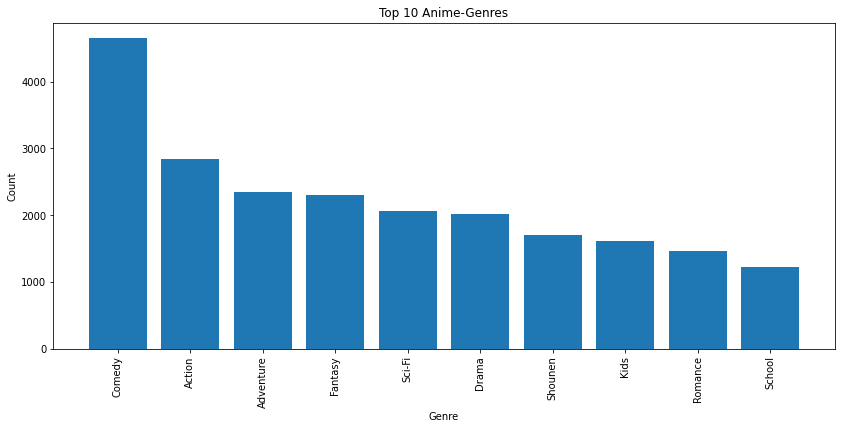

In [113]:
#Plot results in a bar chart
fig = plt.figure(figsize = (14, 6))
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Top 10 Anime-Genres")
plt.xticks(rotation=90)
plt.bar(height=top10_genres_count , x=top10_genres_title )

In [114]:
from collections import Counter

#Count how often a specific type appears in our data set - use the anime dataframe with unique entries
type_count = anime_df["type"].value_counts()
print(type_count)
type_name= Counter(anime_df["type"])
type_name= list(sorted(type_name, key=type_name.get, reverse=True))
print(type_name)

TV            3787
OVA           3311
Movie         2348
Special       1676
ONA            659
Music          488
undefinied      25
Name: type, dtype: int64
['TV', 'OVA', 'Movie', 'Special', 'ONA', 'Music', 'undefinied']


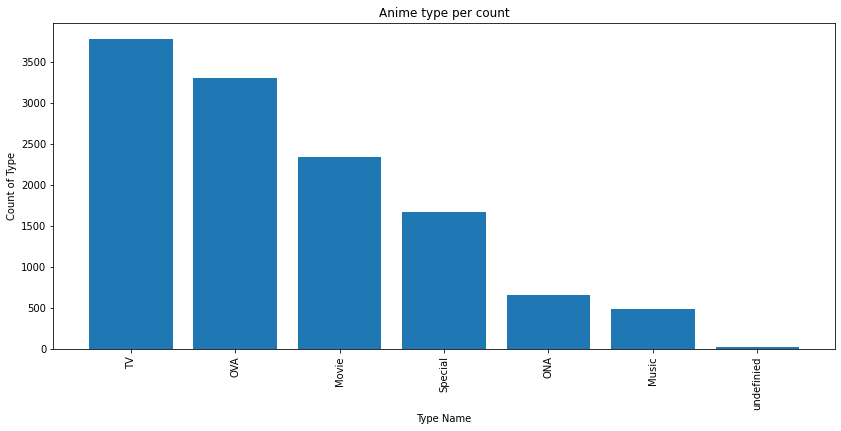

In [115]:
fig = plt.figure(figsize = (14, 6))
plt.xlabel("Type Name")
plt.ylabel("Count of Type")
plt.title("Anime type per count")
plt.xticks(rotation=90)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.bar(height=type_count,x=type_name)
plt.show()

1    64
2    51
3    24
4    51
5    10
Name: episodes, dtype: object
12         747
13         518
26         497
Unknown    209
52         175
Name: episodes, dtype: int64


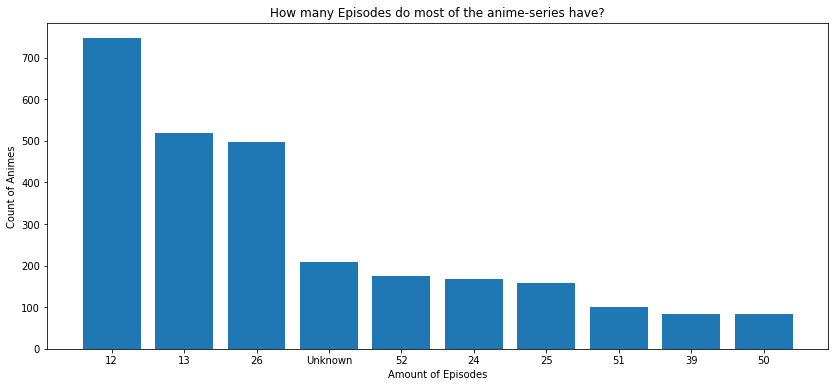

In [116]:
#Count Episodes in Type TV / How many Series got a specific amount of episodes?
# Use the anime dataframe with unique entries
fig = plt.figure(figsize = (14, 6))

#Show only rows which have the type "TV"
tv = anime_df[anime_df.type == "TV"]
print(tv.episodes.head())
episodes_count = tv["episodes"].value_counts()
print(episodes_count.head())
e_t10 = episodes_count[:10]
plt.xlabel("Amount of Episodes")
plt.ylabel("Count of Animes")
plt.title("How many Episodes do most of the anime-series have?")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.bar(height=e_t10, x=list(e_t10.index))
plt.show()

In [117]:
anime_with_ratings.columns

Index(['index', 'user_id', 'anime_id', 'rating', 'name', 'genre', 'type',
       'episodes'],
      dtype='object')

Text(0.5, 1.0, 'w')

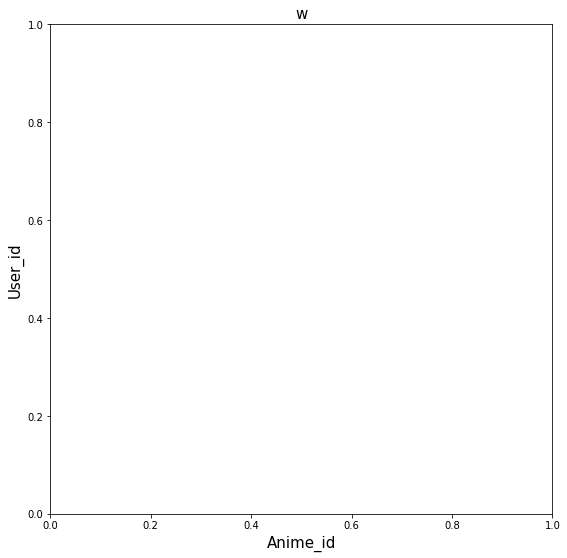

In [118]:
plt.figure(figsize=(9,9))
a = anime_with_ratings[["type", "episodes", "rating"]].groupby(["episodes", "type"]).mean()
plt.xlabel('Anime_id', size = 15)
plt.ylabel('User_id', size = 15)
plt.title('w', size = 15)
#sns.heatmap(a,index ="type", columns="anime_id", values ="rating", annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');

In [119]:
# anime_with_ratings_grouped = anime_with_ratings[["user_id", "rating_y", "name"]].groupby(["rating_y", "name"]).count()
#a = anime_with_ratings[["genre", "anime_id", "rating"]].groupby(["anime_id", "type"]).mean()
#a

In [120]:
#sns.heatmap(sorted_types_rated, title = "Most rated types", xlabel = "", ylabel= "")

In [121]:
#Create a groupby to see which Type got rated the most
types_rated = anime_with_ratings[["type", "rating"]].groupby(["type"]).count()
types_rated.rating
#sort via the values
sorted_types_rated = types_rated.sort_values("rating")
sorted_types_rated

,rating
type,
undefinied,4
Music,19871
ONA,72123
Special,421628
OVA,617166
Movie,842153
TV,4364294


<BarContainer object of 7 artists>

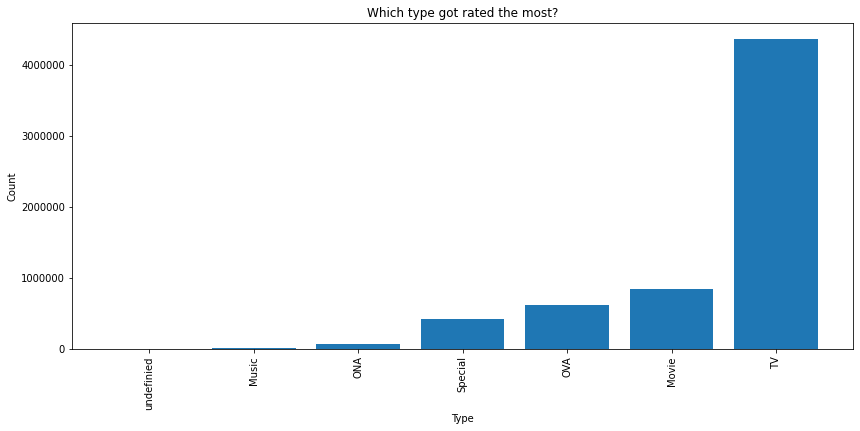

In [122]:
#Plot which anime type got rated the most
fig = plt.figure(figsize = (14, 6))
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Which type got rated the most?")
plt.xticks(rotation=90)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.bar(height=sorted_types_rated.rating, x=sorted_types_rated.index)

In [123]:
#Get mean-values for each anime type via groupby 
meanrating_of_type = anime_with_ratings[["type", "rating"]].groupby(["type"]).mean()
meanrating_of_type
#Sort ratings for types with sort_values
sorted_meanrating_of_type = meanrating_of_type.sort_values("rating")
sorted_meanrating_of_type

,rating
type,
Music,7.214282
ONA,7.229122
OVA,7.334584
Special,7.463639
TV,7.899160
Movie,7.922243
undefinied,8.500000


<BarContainer object of 7 artists>

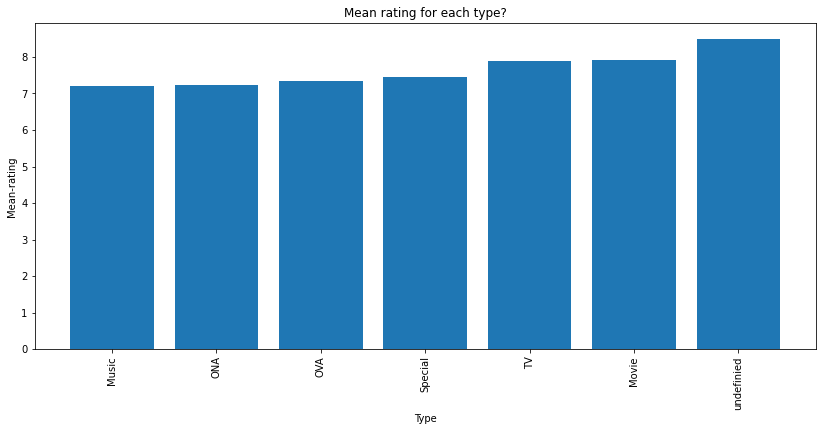

In [124]:
#Plot Bar chart for the mean rating for each anime type
fig = plt.figure(figsize = (14, 6))
plt.xlabel("Type")
plt.ylabel("Mean-rating")
plt.title("Mean rating for each type?")
plt.xticks(rotation=90)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.bar(height=sorted_meanrating_of_type.rating, x=sorted_meanrating_of_type.index)

# ----------------------------------------------------------
# Keep in mind that "undefined" only has 4 ratings in total!
# ----------------------------------------------------------

In [125]:
#c1 = anime_with_ratings[["genre", "rating"]].groupby(["genre"]).count()
#Create a rating matrix, which we can then use for our model

#We have not used the whole dataset here, otherwise the system would be overloaded.
rating_matrix = rating_df[["user_id","anime_id", "rating"]][:2000000]

#Creating the matrix with pivot table function 
rating_matrix = rating_matrix.pivot_table(index="user_id",columns="anime_id",values="rating")
# convert to sparse matrix 
rating_matrix = rating_matrix.astype(pd.SparseDtype("float", np.nan))
print(rating_matrix)

# # convert to numpy matrix
# rating_matrix.to_numpy()
# print(rating_matrix)

anime_id  1      5      6      7      8      ...  34283  34324  34325  34349  34475
user_id                                      ...                                   
1           NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
2           NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3           NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
5           NaN    NaN    8.0    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
7           NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
...         ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
23452       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
23453       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
23454       8.0    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
23455       NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN

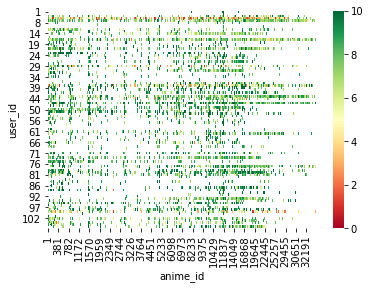

In [126]:
sns.heatmap(rating_matrix[:100], cmap="RdYlGn", vmin=0, vmax=10)

In [127]:
#We have not used the whole dataset here, otherwise the system would be overloaded.
episodes_matrix = anime_with_ratings[["episodes","anime_id", "rating"]]

#Creating the matrix with pivot table function 
episodes_matrix = episodes_matrix.pivot_table(index="anime_id",columns="episodes",values="rating")
print(episodes_matrix)

# convert to numpy matrix
episodes_matrix.to_numpy()
print(episodes_matrix)

#sns.heatmap(episodes_matrix, cmap="RdYlGn")

episodes         1  10  100  1006  101  102  ...  95  96  97  98  99  Unknown
anime_id                                     ...                             
1              NaN NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
5         8.439724 NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
6              NaN NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
7              NaN NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
8              NaN NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
...            ...  ..  ...   ...  ...  ...  ...  ..  ..  ..  ..  ..      ...
34324     5.909091 NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
34325          NaN NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
34349          NaN NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
34367     5.250000 NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN NaN      NaN
34475     6.666667 NaN  NaN   NaN  NaN  NaN  ... NaN NaN NaN NaN

In [128]:
anime_with_ratings

,index,user_id,anime_id,rating,name,genre,type,episodes
0,0,1,8074,10,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
1,1,3,8074,6,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
2,2,5,8074,2,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
3,3,12,8074,6,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
4,4,14,8074,6,Highschool of the Dead,"[Action, Ecchi, Horror, Supernatural]",TV,12
...,...,...,...,...,...,...,...,...
6337234,6337234,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"[Adventure, Drama, SliceofLife]",Special,2
6337235,6337235,69964,33659,6,Fushigi na Somera-chan Special,"[Comedy, Magic, SliceofLife]",Special,1
6337236,6337236,72800,30738,4,Gamba: Gamba to Nakama-tachi,"[Adventure, Kids]",Movie,1
6337237,6337237,73135,8723,5,Anime Rakugo Kan,[Comedy],OVA,4


In [129]:
#Überprüfen ob die Werte so auch wirklich stimmen oder nicht
rating_df[rating_df.anime_id == 20]

,user_id,anime_id,rating
156,3,20,8
306,5,20,6
2282,21,20,8
2795,28,20,9
3114,34,20,9
...,...,...,...
7811138,73495,20,7
7811298,73496,20,10
7811299,73497,20,8
7811363,73499,20,8


In [130]:
#sns.heatmap(anime_with_ratings_grouped, columns="user_id")

## 6. Model selection & implementation
Model selection will contain a discussion about considerations that were made to select a fitting model for this dataset and context. It will also provide the scientific foundation for the selected model and any further considerations that went into the model selection and appropriate metrics that are derived from the model or fed into the model. 

Recommendation systems methods are divided into two categories, that we want to address, before stating which method we chose.

#### **1. Collaborative Filtering**
This approach is based on user-item interactions like ratings, likes and dislikes for a certain item. The basic idea is that users with a similar taste (in this example similar ratings for items) can be identified. Based on those neighbouring / similar users and their content interactions, recommendations can be made. ([Burke et al., 2011](https://ojs.aaai.org/index.php/aimagazine/article/view/2361))

Such user-item interactions are stored in the so called "user-item matrix", where the columns represent the users and the row represent the items or vice versa. The entries in each cell represent the interaction between the item and the user in numeric values, like a rating from 1 to 10. The user-item matrix is sparse, because there are many user-item interactions that didn't occur, yet. The class of collaborative filtering definies how the user-item matrix is populated. These collaborative filtering classes are: memory based and model based.([Xu et al., 2012](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.461.2978&rep=rep1&type=pdf))

##### **memory based**
Memory based collaborative filtering uses similarity metrics to find users with similar preferences from the sparse user-item matrix. According to [Stephen et al., 2017](https://researchrepository.murdoch.edu.au/id/eprint/38661/1/a32-Stephen.pdf) the memory based approach can be represented by 3 steps:
1. Calculate a similarity measure between two users or two items
2. Predict the user-item interaction based on a weighted average over all ratings of the user or item
3. Generate a top X ranking based on that user or item


##### **model based**
The model based approach uses machine learning to build a model that can describe the user preferences that are already present in the user-item matrix. That model is then used to fill in the gaps in the user-item matrix and therefore predict how different users would interact with a certain item.
That information is then used to give recommendations to the user. ([Yu et al., 2004](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.329.8903&rep=rep1&type=pdf))



</br>
</br>

#### **2. Content-based filtering**
This approach analyses the user preferences and tries to find similarities in the prefered items of that specific user ([Reddy et al., 2019](https://www.academia.edu/download/62049148/contentbased20200209-27698-l8hk2i.pdf)). It does so by using attributes of the prefered items such as genre, brand, publisher, type and so on. Therefore, the user profile is based on inherent information of the items prefered by them, in contrast to collaborative filtering, where the user profile is based on other users preferences.

According to [Reddy et al., 2019](https://www.academia.edu/download/62049148/contentbased20200209-27698-l8hk2i.pdf) there are three methods of content based filtering:

1. **Wrapper methods** that split features of the items into subsets and evaluates which subset is most relevant
2. **Filter Methods** that rank the relevance of features with a heuristic
3. **Embedded Methods** use a Machine Learning algorithm that selects relevant features during the training phase


### **Selecting the model**

After what has been learned about different approaches to recommender systems, which method is the best fit for the dataset and the context of anime recommendation.

First of all both content-based filtering and collaborative filtering would be possible, as the dataset has some features for each anime and also thousands of preferences for different users.

Based on the [this](https://arxiv.org/pdf/1905.01395.pdf) study by Rendle et al. in 2019 Matrix factorization is not only a baseline model for recomender systems, but can even outperform newly proposed models if used properly. Rendle et al. research also indicates that matrix factorization is a good fit for datasets such as the Netflix Prize as seen in [this](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.115.6998&rep=rep1&type=pdf) paper or the movielense dataset. Both of these datasets have similar features as the anime dataset, that is used in this Jupyter Notebook.


The general mechanics of matrix factorization are, that we have a sparse matrix with user ratings. It is sparse because there are alot of anime that many users haven't watched. In other words there are many user-anime combinations, but only few of them occured and resulted in a user rating an anime.

The objective of matrix factorization is to fill the sparse matrix. This is achieved by splitting the matrix $M$ into factors $A$ and $B$, that when multiplied, result in approximately the same Matrix:

$ M \approx A \times B $

In this context:

$A = \begin{pmatrix}
User1 & \dots & UserN\\
\dots & \dots & \dots\\
value_{1m} & \dots & value_{nm}
\end{pmatrix}$  is called User-Feature Matrix 


$B = \begin{pmatrix}
Anime1 & \dots & AnimeN\\
\dots & \dots & \dots\\
value_{1m} & \dots & value_{nm}
\end{pmatrix}$  is called Anime-Feature Matrix 


This will result in the empty cells of the Matrix also beeing populated. To fit the factors, so that they can represent the entries in matrix $M$ as good as possible, a cost function is used to optimize $A$ and $B$.

The next step is to build a matrix factorization class, that we can use to fit, train and use the model. First of all a cost function for the matrix factorization model needs to be implemented. Mean squared Error will be used for this task.

In [158]:
class MFModel():
  """
  Model to fit, train and apply matrix factorisation for anime recommendation.
  The Matrix should have the structure users (rows) x animes (columns)

  Parameters:
  ----
  df: 1-D pd.DataFrame with user and anime ids, that are used to create a tensor with dimensions N x M where N = users, M = animes
  num_features: number of features that user- and anime-feature matrix will have. More features are computational expensive, but result in fine granular results
  """

  def __init__(self, df, num_features):
    #### Init data structures ####
    # save the dataframe, as it can be used for further data manipulation 
    self.df = df
    # save the matrix as a tensorflow tensor
    self.matrix = self.create_matrix(df)
    print(f"\n ========= Init Model =========\n")
    print(f"TensorFlow Matrix with shape {self.matrix.shape} was created")
   
    # Data split, that can be used with train_split() function
    self.split_data = {
        "train": None, # will hold the train tensor
        "test": None # will hold test tensor
        }
    self.split_df = {
        "train": None, # will hold the train df
        "test": None # will hold test df
        }
    self.feature_matrices = {
        "train": {          # both feature matrices for the train dataset
            "users": None,
            "animes": None
        },
        "test": {           # both feature matrices for the test dataset
            "users": None,
            "animes": None
        }
    }

    #### Metadata ####
    # num of rows = num of users
    self.num_users = self.matrix.shape[0]
    # num of columns = num of animes
    self.num_animes = self.matrix.shape[1]
    self.num_cells = self.num_animes * self.num_users
    self.num_features = num_features
    # mean of matrix rating, ignoring NaN
    self.mean = np.nanmean(self.df["rating"].values)
    print(f"\nThe mean of the input matrix is: {self.mean}")
    # standard deviation of matrix ratings, ignoring NaN
    self.std = np.nanstd(self.df["rating"].values)
    print(f"The standard deviation of the input matrix is: {self.std}")

  def create_matrix(self, df, row="user_id", col="anime_id"):
    """
    Takes a input pandas dataframe and creates a tf.SparseTensor
    with column and row indices with sequential indices that start with 0.

    Param
    ---- 
    df: A 1-D pd.DataFrame with 3 columns for user, anime (name for those are definied with the other params) and "rating"
    row: name of the column in the dataframe that will be used as rows in the tensor
    col: name of the column in the dataframe that will be used as columns in the tensor
    """
    #df_cp = df.copy()
    # create sorted list of unique user and item ids
    row_ids = df[row].unique().tolist()
    row_ids.sort()
    col_ids = df[col].unique().tolist()
    col_ids.sort()
    # we count: row = unique users and col = unique animes
    num_rows = len(row_ids)
    num_cols = len(col_ids)
    # create sequential ids
    row_ids_seq = list(range(num_rows))
    col_ids_seq = list(range(num_cols))

    # create dictionary that maps existing non-sequential ids to new sequential ids
    replace_rows_map = {key:value for key, value in zip(row_ids, row_ids_seq)}
    replace_cols_map = {key:value for key, value in zip(col_ids, col_ids_seq)}

    # reindex to have sequential indices that start from 0
    df[row].replace(replace_rows_map, inplace=True)
    df[col].replace(replace_cols_map, inplace=True)
    
    #print(df_cp.head(5))

    # create sparse tensor with dimensions USER x ANIME
    return tf.SparseTensor(
        indices=df[[row, col]].values,
        values=df["rating"].values,
        dense_shape=[num_rows, num_cols]
    )
     



  def init_feature_matrices(self):
    """
    Initilizes feature matrices for train and test tensors.
    Where the feature matrices have shape:
    user feature matrix: (USERS x Features) 
    anime feature matrix: (Features x ANIMES) 
    So that rating_matrix is approximately (USERS x Features) X (Features x ANIMES) 
    """
    # construct a random normal distribution of values that roughly equals 
    # the mean and standard deviation of the original matrix
    # We multiply every feature matrices like so: 
    # user feature matrix of shape (num_users X num_features) := A
    # Anime feature matrix of shape (num_features X num_animes) := B
    # M = A x B
    # where each cell (i,j) in matrix M is the sum over row i in A multiplied with col j in B
    adjusted_mean = (self.mean**0.5)/self.num_features
    adjusted_std = (self.mean**0.5)/self.num_features

    #### Init train matrices ####
    # shape of train tensor
    train_users, train_animes = self.split_data["train"].shape # shape is USERS x ANIMES
    self.feature_matrices["train"]["users"] = tf.random.normal(
        [train_users, self.num_features], # shape USERS x Features
        mean=adjusted_mean, stddev=adjusted_std, dtype=tf.float16
        )
    self.feature_matrices["train"]["animes"] = tf.random.normal(
        [self.num_features, train_animes], # shape Features x ANIMES
        mean=adjusted_mean, stddev=adjusted_std, dtype=tf.float16
        )
    
    print(f"\nCreated train feature matrices with shape USERS = {self.feature_matrices['train']['users'].shape} and ANIMES = {self.feature_matrices['train']['animes'].shape}")
    
    #### Init test matrices ####
    test_users, test_animes = self.split_data["test"].shape # shape is USERS x ANIMES
    self.feature_matrices["test"]["users"] = tf.random.normal(
        [test_users, self.num_features], # shape USERS x Features
        mean=adjusted_mean, stddev=adjusted_std, dtype=tf.float16
        )
    self.feature_matrices["test"]["animes"] = tf.random.normal(
        [self.num_features, test_animes], # shape Features x ANIMES
        mean=adjusted_mean, stddev=adjusted_std, dtype=tf.float16
        )

    print(f"Created test feature matrices with shape USERS = {self.feature_matrices['test']['users'].shape} and ANIMES = {self.feature_matrices['test']['animes'].shape}\n")    

  def train_split(self, train=0.7):
    """
    Split dataframe into training and test data.

    Param
    ---
    train: percentage of tensor data, that will be training data
    test: 1 - train is automatically used for test percentage
    """
    if train > 1.0:
      raise ValueError("Please insert valid data split. Train and test data should sum up to 100%")
    
    # assign train % of the dataframe to train dataset
    self.split_df["train"] = self.df.sample(frac=train)
    # assign rest of the dataset to test dataset and shuffle the data
    self.split_df["test"] = self.df.drop(self.split_df["train"].index).sample(frac=1.0)

    # convert to tensor and save in instance
    self.split_data["train"] = self.create_matrix(self.split_df["train"])
    self.split_data["test"] = self.create_matrix(self.split_df["test"])

    print("\n========= Created train and test split =========\n")
    # create anime and user feature matrices for the fresh split
    self.init_feature_matrices()


  def transform_matrix(self, matrix):
    """
    Transforms the matrix to encorporate percentage values, as rating values between 0 and 1 
    are not prone for arithmetic overflow and extensive memory usage. Arithmetic underflow is not
    a problem, because each iteration only two values are multiplied.
    """
    # find max and min entry and ignore nan values
    max = np.nanmax(matrix)
    min = np.nanmin(matrix)
    return (matrix - min)/(max - min) 

  # MSE Cost function for matrix factorization
  def mse(self, split="train", verbose=False):
    '''
    Calculates the mean square error between the product of anime-feature x user-feature and the corresponding cell in Matrix M, based on data that was fit to the object.

    Param
    ---
    split: str that specifies if train or test dataset should be used to calculate mse
    '''
    # user and anime matrices for the selected datasplit (train or test)
    user_mat = self.feature_matrices[split]["users"]
    anime_mat = self.feature_matrices[split]["animes"]
    # Original train or test tensor
    orig_mat = self.split_data[split]

    # multiply the feature matrices and
    # select the values where the original matrix has entries
    # (we can't calculate mse if the original matrix was empty in that cell)
    pred = tf.gather_nd(
        tf.matmul(user_mat, anime_mat), 
        orig_mat.indices
        )
    
    if verbose:
      print("user features: ", user_mat)
      print("anime features: ", anime_mat)
      print("prediction: ", pred)
      print("original: ", orig_mat.values)

    print(f"\n========= Mean Squared Error =========\n")
    print(f"Calculating mse over {pred.shape} values")

    # calculate mse between original matrix and predictions
    mse = tf.losses.mean_squared_error(orig_mat.values, pred)
    print(f"Mean Squared Error is: {mse}")
    return mse



In [160]:
# create the matrix factorization model
# Using the whole dataset might crash the session because of RAM restriction, so only use a sample
# The hyperparameter number of features also called embeddings can be selected here
model = MFModel(rating_df[:100000], 5)
# Split the data into train and test dataset
model.train_split(train=0.7)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,



 ========= Init Model =========

TensorFlow Matrix with shape (1203, 5924) was created

The mean of the input matrix is: 7.86499
The standard deviation of the input matrix is: 1.5478573254340984

========= Created train and test split =========


Created train feature matrices with shape USERS = (1178, 5) and ANIMES = (5, 5498)
Created test feature matrices with shape USERS = (1123, 5) and ANIMES = (5, 4407)



In [161]:
mse = model.mse(split="train", verbose=False)


========= Mean Squared Error =========

Calculating mse over (70000,) values
Mean Squared Error is: 43.59375


## 7. Model training 
The dataset will be split into train and test samples and the model will be trained to give anime recommendations based on any users data.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

#Make sure that the columns have the right type before appending them
anime_df["genre"] = anime_df["genre"].replace(np.nan, "undefinied")
anime_df["type"] = anime_df["type"].replace(np.nan, "undefinied")

anime_df["name"] =anime_df["name"].astype(str)
anime_df["type"] = anime_df["type"].astype(str)
anime_df["genre"] = anime_df["genre"].astype(str)
anime_df.index = anime_df["anime_id"]
#function which creates the column with the important informations automatically
'''def get_important_features(data):
  important_features= []

  for i in range(0, data.shape[0]):
      important_features.append(data["name"][i]+ ' ' +data["type"][i]) 
    
  return get_important_features'''

#Check if all columns have some values
colums=["name", "type", "genre"]

#If there are Null Values contained in the DataFrame, an TypeError with messame "Not String" will occure
if anime_df[colums].isnull().values.any():
  raise TypeError('NotString')




#Get the important features for each row
#testing["important_feats"] = get_important_features(testing)
anime_df

,anime_id,name,genre,type,episodes
anime_id,,,,,
32281,32281,Kimi no Na wa.,"['Drama', 'Romance', 'School', 'Supernatural']",Movie,1
5114,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",TV,64
28977,28977,Gintama°,"['Action', 'Comedy', 'Historical', 'Parody', '...",TV,51
9253,9253,Steins;Gate,"['Sci-Fi', 'Thriller']",TV,24
9969,9969,Gintama&#039;,"['Action', 'Comedy', 'Historical', 'Parody', '...",TV,51
...,...,...,...,...,...
9316,9316,Toushindai My Lover: Minami tai Mecha-Minami,['Hentai'],OVA,1
5543,5543,Under World,['Hentai'],OVA,1
5621,5621,Violence Gekiga David no Hoshi,['Hentai'],OVA,4


In [ ]:
#Alternative way as the function does not work
anime_df["important_feats"] = anime_df["name"]+ ' ' + anime_df["type"]+ ' ' + anime_df["genre"]
anime_df

,anime_id,name,genre,type,episodes,important_feats
anime_id,,,,,,
32281,32281,Kimi no Na wa.,"['Drama', 'Romance', 'School', 'Supernatural']",Movie,1,"Kimi no Na wa. Movie ['Drama', 'Romance', 'Sch..."
5114,5114,Fullmetal Alchemist: Brotherhood,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",TV,64,"Fullmetal Alchemist: Brotherhood TV ['Action',..."
28977,28977,Gintama°,"['Action', 'Comedy', 'Historical', 'Parody', '...",TV,51,"Gintama° TV ['Action', 'Comedy', 'Historical',..."
9253,9253,Steins;Gate,"['Sci-Fi', 'Thriller']",TV,24,"Steins;Gate TV ['Sci-Fi', 'Thriller']"
9969,9969,Gintama&#039;,"['Action', 'Comedy', 'Historical', 'Parody', '...",TV,51,"Gintama&#039; TV ['Action', 'Comedy', 'Histori..."
...,...,...,...,...,...,...
9316,9316,Toushindai My Lover: Minami tai Mecha-Minami,['Hentai'],OVA,1,Toushindai My Lover: Minami tai Mecha-Minami O...
5543,5543,Under World,['Hentai'],OVA,1,Under World OVA ['Hentai']
5621,5621,Violence Gekiga David no Hoshi,['Hentai'],OVA,4,Violence Gekiga David no Hoshi OVA ['Hentai']


In [ ]:
#Fitting the column with the important informations in cosine
cm = CountVectorizer().fit_transform(anime_df["important_feats"])
cs = cosine_similarity(cm)
print(cs)

[[1.         0.10050378 0.         ... 0.12598816 0.10540926 0.27216553]
 [0.10050378 1.         0.28603878 ... 0.         0.         0.        ]
 [0.         0.28603878 1.         ... 0.         0.         0.        ]
 ...
 [0.12598816 0.         0.         ... 1.         0.83666003 0.3086067 ]
 [0.10540926 0.         0.         ... 0.83666003 1.         0.25819889]
 [0.27216553 0.         0.         ... 0.3086067  0.25819889 1.        ]]


In [ ]:
#Choosing a Anime 
anime_name =anime_df["name"][20]
anime_name
print(anime_name)

#Getting the Id from the Anime
anime_id =  anime_df[anime_df.name==anime_name]["anime_id"].values[0]
anime_id

Naruto


20

In [ ]:
#Printing the highest Scores/Similaritys for our Anime
scores = list(enumerate(cs[anime_id]))
sorted_scores = sorted(scores, key = lambda x:x[1], reverse=True)
# Top 4
sorted_scores = sorted_scores[1:5] 
sorted_scores

[(44, 0.9428090415820634),
 (32, 0.8944271909999159),
 (279, 0.784464540552736),
 (162, 0.7071067811865475)]

In [ ]:
#Printing the Top 4 recommended Animes
j = 0
print("The 4 Most recommended animes for you, because you liked" + ' '+ anime_name + ' ' +"are:\n")
for item in sorted_scores:
    anime_title =  anime_df[anime_df.anime_id==item[0]]["name"].values[0]
    print(j+1, anime_title)
    j = j+1
    if j>=4:
        break

The 4 Most recommended animes for you, because you liked Naruto are:

1 Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen
2 Neon Genesis Evangelion: The End of Evangelion
3 Kyougoku Natsuhiko: Kousetsu Hyaku Monogatari
4 Pita Ten
